In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder , OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import KBinsDiscretizer , Binarizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


In [46]:
df = pd.read_csv('Flight_data.csv')

In [47]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [48]:
df.drop(columns=['Unnamed: 0', 'flight'], inplace=True)


In [49]:
df.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


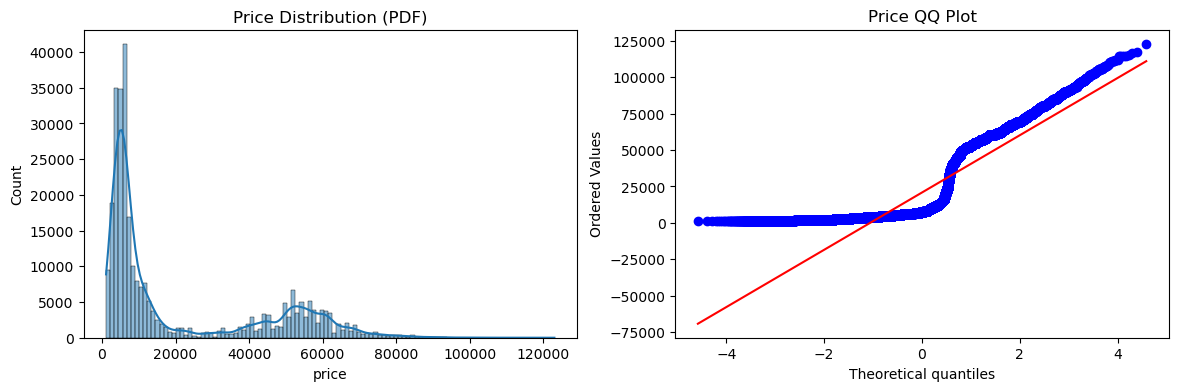

In [50]:
plt.figure(figsize=(14,4))

plt.subplot(121)
sns.histplot(df['price'], kde=True)
plt.title('Price Distribution (PDF)')

plt.subplot(122)
stats.probplot(df['price'], dist="norm", plot=plt)
plt.title('Price QQ Plot')

plt.show()

In [51]:
route_duration_map = (
    df.groupby(['source_city', 'destination_city'])['duration']
      .mean()
      .reset_index()
      .rename(columns={'duration': 'route_avg_duration'})
)

df = df.merge(
    route_duration_map,
    on=['source_city', 'destination_city'],
    how='left'
)
df.drop(columns=['duration'] , inplace =True)

In [52]:
df = df[df['price'] < df['price'].quantile(0.99)]


In [53]:
df

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,days_left,price,route_avg_duration
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,1,5953,10.367774
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,1,5953,10.367774
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,1,5956,10.367774
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,1,5955,10.367774
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,1,5955,10.367774
...,...,...,...,...,...,...,...,...,...,...
300144,Air_India,Chennai,Evening,one,Morning,Hyderabad,Business,49,51345,13.153985
300145,Air_India,Chennai,Morning,one,Morning,Hyderabad,Business,49,51345,13.153985
300146,Air_India,Chennai,Early_Morning,one,Morning,Hyderabad,Business,49,51345,13.153985
300147,Air_India,Chennai,Early_Morning,one,Night,Hyderabad,Business,49,68739,13.153985


In [54]:
X = df.drop('price', axis=1)
y = df['price']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [56]:
lt = FunctionTransformer(func=np.log1p)
y_train_trans = lt.transform(y_train)
y_test_trans = lt.transform(y_test)

In [57]:
y_train

32899      2022
76507      3098
24572      6821
116040    10744
119159     1604
          ...  
119879    22869
260586    60396
131932     5102
146867     5574
121958     6339
Name: price, Length: 237714, dtype: int64

In [58]:
df['departure_time'].unique()

array(['Evening', 'Early_Morning', 'Morning', 'Afternoon', 'Night',
       'Late_Night'], dtype=object)

In [59]:
transformations = ColumnTransformer(
    transformers=(
        ('scale' , StandardScaler() , ['days_left']) ,
        ('stops_oe' , OrdinalEncoder(categories=[['zero' , 'one' , 'two_or_more']] ,handle_unknown='use_encoded_value', unknown_value=-1) , ['stops']) ,

        ('arrival_time_oe', OrdinalEncoder(categories=[[
            'Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night'
                    ]] , handle_unknown='use_encoded_value', unknown_value=-1), ['arrival_time']),

       ('class_oe' , OrdinalEncoder(categories=[['Economy', 'Business']] , handle_unknown='use_encoded_value', unknown_value=-1) , ['class']) ,

       ('departure_time_oe', OrdinalEncoder(categories=[[
                'Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late_Night'
                    ]] , handle_unknown='use_encoded_value', unknown_value=-1), ['departure_time']) ,

       ('OHE' , OneHotEncoder(drop='first' , sparse_output= False , handle_unknown='ignore') , ['airline' , 'source_city' , 'destination_city'])
    ) ,
    remainder='passthrough'
)

In [60]:
transformations.fit(X_train)

,transformers,"(('scale', ...), ...)"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [61]:
X_train_transf = transformations.transform(X_train)
X_test_transf = transformations.transform(X_test)


In [ ]:
feature_names = transformations.get_feature_names_out()

X_full_transformed = transformations.transform(X)

X_full_df = pd.DataFrame(X_full_transformed, columns=feature_names)

X_full_df['price'] = y.reset_index(drop=True)

X_full_df.to_csv("flight_transformed_final.csv", index=False)


